In [2]:
import numpy as np
from matplotlib import pyplot as plt
import math
import planet_sampler_pop as ps
import pandas as pd
from scipy import stats  
import scipy.optimize as opt
%matplotlib inline

In [3]:
def snr_weiss(R_p, R_star, M_star, period, CDPP_6h):
    """
    snr_weiss : Computes the expected signal to noise ratio of a planet with size R_p and orbital period
    period orbiting a star with bulk density rho_star and radius R_star and a 6hr combined differential photometric precision 
    CDPP_6hr. This definition is taken from Weiss et al. 2018 https://iopscience.iop.org/article/10.3847/1538-3881/aa9ff6
    #####
    Parameters : 
    R_p : planet radius in Earth radius
    R_star : host star radius in solar radius
    M_star: host star mass in stellar mass
    period : period in days
    CDPP_6h : combined differential photometric precision over 6hr
    
    returns the value of SN ratio
    """
    
    rho = M_star/(R_star**3) # Approx density of the star in units of sun density
    #getting planet and star radius in the same units
    R_p = R_p * 6371.000
    R_star = 695510* R_star
    T = 13 * (period/365.2422)**(1/3) * (rho)**(-1/3) # Parameter T in hours
    print((R_p/R_star)**2 * math.sqrt(3.5 / (period/365.2422 )) / (CDPP_6h * math.sqrt(6/T)))
    return  (R_p/R_star)**2 * math.sqrt(3.5 / (period/365.2422 )) / (CDPP_6h * math.sqrt(6/T))


def swapping_criterion(R_p, R_star, M_star, period, CDPP_6h, snr_threshold = 10):
    snr_weiss(R_p, R_star, M_star, period, CDPP_6h)
    return True
    #return snr_weiss(R_p, R_star, M_star, period, CDPP_6h) > snr_threshold
    
def gaussian_fit(x, mu, sigma):
    return 1/math.sqrt(2*math.pi*sigma**2) * np.exp(-(x - mu)**2/(2*sigma**2))


## Importing the data

In [19]:
original_planets = ps.PlanetSample("emile_testing_AG13_bright5_baseline.txt", dataset = "SAG")
#life_planets = ps.PlanetSample("emile_testing_AG13_bright5_weiss.txt", dataset = "SAG")
life_planets = ps.PlanetSample("kerneltest_SAG13_bright5_weiss.txt", dataset = "SAG")


## Trying to implement the same tests as Weiss et al. for original sample

In [5]:
periods_plus = []
periods_minus = []
nMC = 5
for i in range(nMC):    
    for snumber in range(326):
        a = original_planets.a[np.logical_and(original_planets.snumber == snumber, original_planets.nMC == i)]
        if(len(a) > 2): # If there are more than 2 planets in the system
            #print("Simulation " + str(i))
            periods_temp = original_planets.period[np.logical_and(original_planets.snumber == snumber, original_planets.nMC == i)][a.argsort()]
            #as_temp = a[a.argsort()]
            periods_temp_plus = periods_temp[2:]/(periods_temp[1:-1])
            periods_temp_minus = periods_temp[1:-1]/periods_temp[0:-2]
            periods_plus.append(periods_temp_plus)
            periods_minus.append(periods_temp_minus)
        else:
            pass
        #print("This system does not have enough planets in simulation " + str(i))
periods_plus_kam = np.array(periods_plus)
periods_minus_kam = np.array(periods_minus)

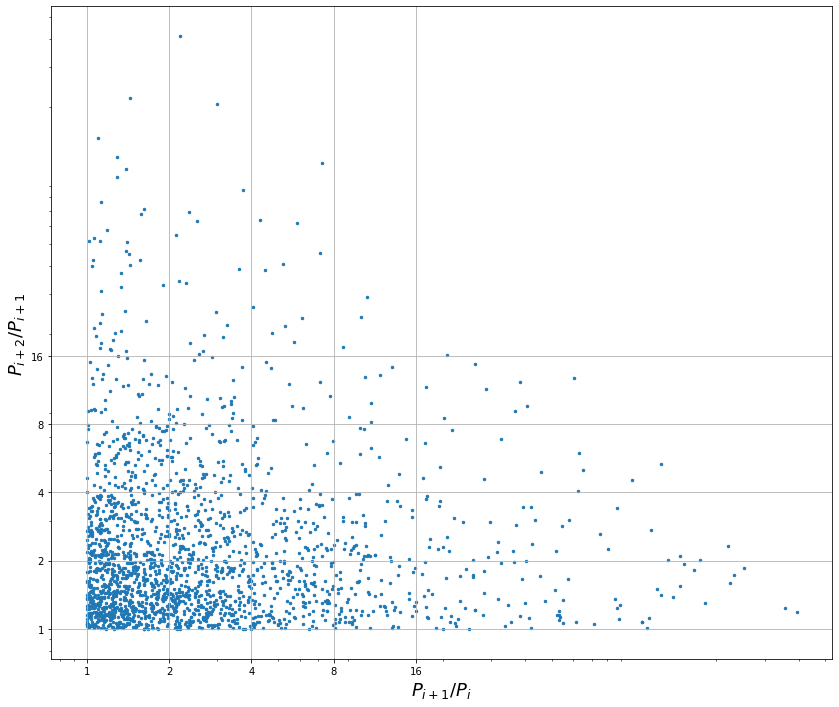

In [6]:
plt.figure(figsize = (14,12))
plt.scatter(np.concatenate(periods_minus_kam), np.concatenate(periods_plus_kam), s = 6, linewidth = 1)
plt.ylabel("$P_{i+2}/P_{i+1}$ ", fontsize = 18)
plt.xlabel("$P_{i+1}/P_i$", fontsize = 18)
plt.xscale("log")
plt.yscale("log")
plt.xticks([1,2,4,8,16], [1,2,4,8,16])
plt.yticks([1,2,4,8,16], [1,2,4,8,16])
plt.grid()

## For corrected sample

In [20]:
periods_plus = []
periods_minus = []
nMC = 5
for i in range(nMC):    
    for snumber in range(326):
        periods = np.sort(life_planets.period[np.logical_and(life_planets.snumber == snumber, life_planets.nMC == i)])
        if(len(periods) > 2): # If there are more than 2 planets in the system
            #print("Simulation " + str(i)) 
           # print("max : " + str(max(periods_temp)) + ", min : " + str(min(periods_temp)))
            #as_temp = a[a.argsort()]
            periods_temp_plus = periods[2:]/(periods[1:-1])
            periods_temp_minus = periods[1:-1]/periods[0:-2]
            periods_plus.append(periods_temp_plus)
            periods_minus.append(periods_temp_minus)
        else:
            pass
        #print("This system does not have enough planets in simulation " + str(i))
periods_plus_life = np.concatenate(np.array(periods_plus))
periods_minus_life = np.concatenate(np.array(periods_minus))

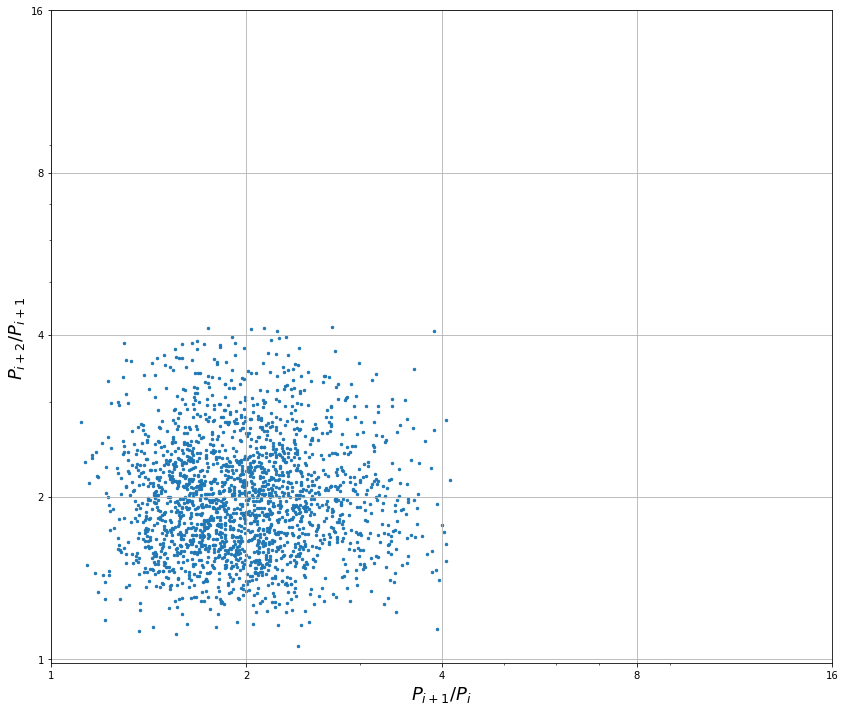

In [21]:
plt.figure(figsize = (14,12))
plt.scatter(periods_minus_life, periods_plus_life, s = 6, linewidth = 1)
plt.ylabel("$P_{i+2}/P_{i+1}$ ", fontsize = 18)
plt.xlabel("$P_{i+1}/P_i$", fontsize = 18)
plt.xscale("log")
plt.yscale("log")
plt.xticks([1,2,4,8,16], [1,2,4,8,16])
plt.yticks([1,2,4,8,16], [1,2,4,8,16])
plt.grid()

## Using Weiss' et al dataset

In [9]:
weiss_data = pd.read_csv("weiss_tables.csv")

In [10]:
periods_plus = []
periods_minus = []
periods_ratio = []
count = 0
for kois in weiss_data.KOIS.unique():
    periods = np.array(weiss_data.planet_period[weiss_data.KOIS == kois].sort_values()) # We get all the periods for a given star and sort them
    if(len(periods) >= 3 ):
        count += 1
        periods_temp_ratio = periods[1:]/periods[:-1]
        periods_temp_plus = periods[2:]/(periods[1:-1])
        periods_temp_minus = periods[1:-1]/periods[0:-2]
        periods_ratio.append(periods_temp_ratio)
        periods_plus.append(periods_temp_plus)
        periods_minus.append(periods_temp_minus)
periods_ratio = np.concatenate(periods_ratio)
periods_plus = np.concatenate(np.array(periods_plus))
periods_minus = np.concatenate(np.array(periods_minus))
periods_plus_weiss = periods_plus#[np.logical_and(periods_minus <= 4, periods_plus <= 4)]
periods_minus_weiss = periods_minus#[np.logical_and(periods_minus <= 4, periods_plus <= 4)]
print(count)

129


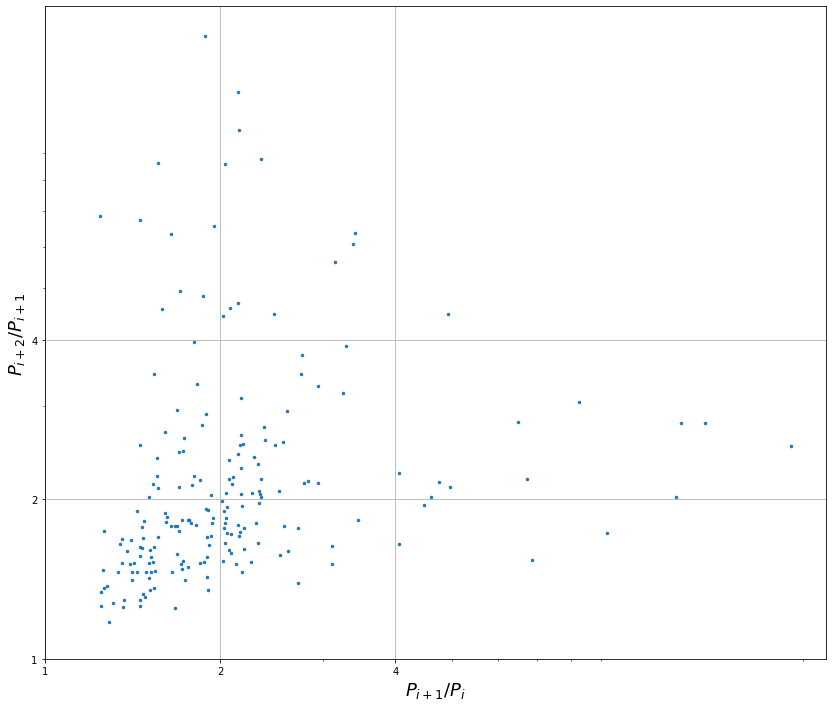

In [11]:
plt.figure(figsize = (14,12))
plt.scatter(periods_minus_weiss, periods_plus_weiss, s = 6, linewidth = 1)
plt.ylabel("$P_{i+2}/P_{i+1}$ ", fontsize = 18)
plt.xlabel("$P_{i+1}/P_i$", fontsize = 18)
plt.xscale("log")
plt.yscale("log")
plt.xticks([1,2,4], [1,2,4])
plt.yticks([1,2,4], [1,2,4])
plt.grid()

## Comparing the 3 with an histogram

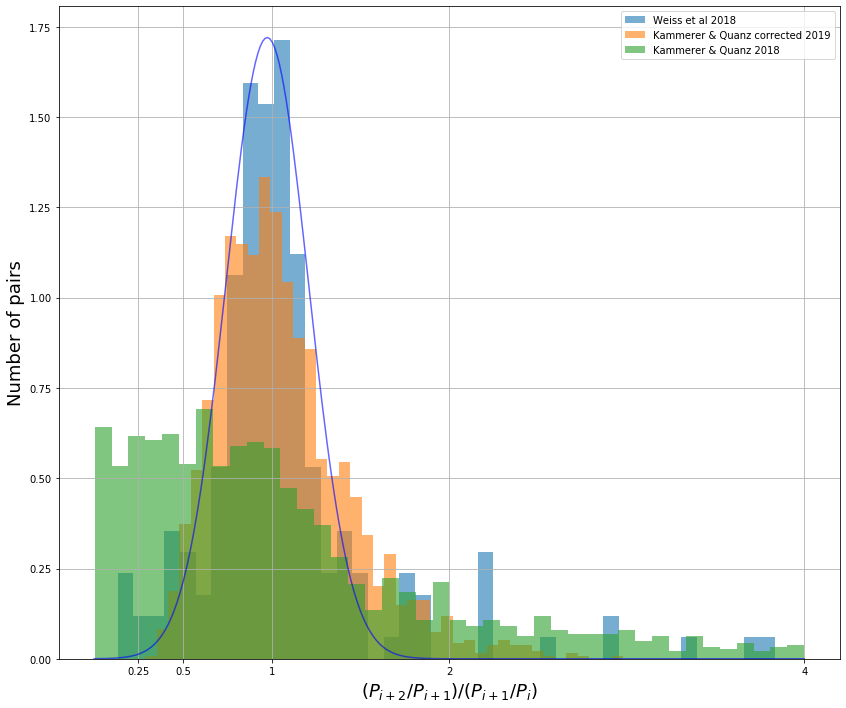

In [22]:
plt.figure(figsize = (14,12))
temp = (periods_plus_weiss /periods_minus_weiss) 
temp = temp[(temp < 4)]

temp_life = (periods_plus_life / periods_minus_life)
temp_life = temp_life[(temp_life < 4)]
temp_kam = np.concatenate(periods_plus_kam / periods_minus_kam)
temp_kam = temp_kam[(temp_kam < 4)]
entries, bin_edges, patches  =plt.hist(temp, bins = 42, density=True, alpha = 0.6, label = "Weiss et al 2018")
plt.hist(temp_life, bins = 42, density = True, alpha = 0.6, label = "Kammerer & Quanz corrected 2019")
plt.hist(temp_kam, bins = 42, density = True, alpha = 0.6, label = "Kammerer & Quanz 2018")
bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])
popt_gauss, pcov_gauss = opt.curve_fit(gaussian_fit, bin_middles,entries )
x_plot = np.linspace(0,4, 300)
plt.plot(x_plot, gaussian_fit(x_plot, popt_gauss[0], popt_gauss[1]), color = "b", alpha = 0.6)
plt.xlabel("$(P_{i+2} / P_{i+1}) / (P_{i+1} / P_{i})$", fontsize = 18)
plt.ylabel("Number of pairs", fontsize = 18)
plt.xticks([0.25,0.5,1,2,4], [0.25,0.5,1,2,4])
plt.grid()
plt.legend()